
# Árvore de Decisão — Sintomas de COVID (Didático)

**Formato:** explicação ➜ código ➜ explicação (sempre).  
**Objetivo:** entender **como se gera**, **como se poda** (pré e pós), **como avaliar** e **como interpretar** uma árvore de decisão, usando um dataset simples de **sintomas de COVID**.



## 1) Entendimento do problema e dos dados (explicação)

- **Tarefa**: classificar um paciente como `positivo` ou `negativo` para COVID a partir de sintomas e contexto simples.  
- **Atributos** (todos categóricos):  
  `faixa_etaria`, `vacinado`, `febre`, `tosse`, `dor_garganta`, `falta_ar`, `fadiga`, `contato_confirmado`.  
- **Alvo**: `resultado` (`positivo`/`negativo`).

A ideia é **aprender regras** do tipo **SE** `febre=sim` **E** `contato_confirmado=sim` **ENTÃO** `positivo`, etc.


In [1]:

# Importações
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Reprodutibilidade
np.random.seed(42)

# Caminho padrão do dataset sintético
csv_path = "dataset-sintetico-covid.csv"

# Se já existir um CSV (por exemplo, você fez upload), usamos; caso contrário, geramos um dataset simples.
if not os.path.exists(csv_path):
    n = 600
    age_groups = np.random.choice(["0-17","18-39","40-59","60+"], size=n, p=[0.15,0.45,0.25,0.15])
    vaccinated = np.random.choice(["sim","nao"], size=n, p=[0.7,0.3])
    fever = np.random.choice(["sim","nao"], size=n, p=[0.55,0.45])
    cough = np.random.choice(["sim","nao"], size=n, p=[0.6,0.4])
    sore_throat = np.random.choice(["sim","nao"], size=n, p=[0.4,0.6])
    short_breath = np.random.choice(["sim","nao"], size=n, p=[0.3,0.7])
    fatigue = np.random.choice(["sim","nao"], size=n, p=[0.5,0.5])
    contact_confirmed = np.random.choice(["sim","nao"], size=n, p=[0.2,0.8])

    # Gerar rótulo com alguma lógica + ruído
    prob = (
        0.15
        + 0.25*(fever=="sim").astype(int)
        + 0.25*(cough=="sim").astype(int)
        + 0.15*(short_breath=="sim").astype(int)
        + 0.10*(fatigue=="sim").astype(int)
        + 0.20*(contact_confirmed=="sim").astype(int)
        + 0.10*(age_groups=="60+").astype(int)
        - 0.15*(vaccinated=="sim").astype(int)
    )
    prob = np.clip(prob, 0.02, 0.95)
    y = (np.random.rand(n) < prob).astype(int)
    label = np.where(y==1, "positivo", "negativo")

    df = pd.DataFrame({
        "faixa_etaria": age_groups,
        "vacinado": vaccinated,
        "febre": fever,
        "tosse": cough,
        "dor_garganta": sore_throat,
        "falta_ar": short_breath,
        "fadiga": fatigue,
        "contato_confirmado": contact_confirmed,
        "resultado": label
    })
    df.to_csv(csv_path, index=False)
else:
    df = pd.read_csv(csv_path)

print("Tamanho:", df.shape)
df.head()


Tamanho: (600, 9)


,faixa_etaria,vacinado,febre,tosse,dor_garganta,falta_ar,fadiga,contato_confirmado,resultado
0,18-39,sim,nao,nao,sim,nao,sim,nao,negativo
1,60+,sim,sim,nao,sim,nao,nao,sim,positivo
2,40-59,sim,sim,sim,nao,sim,sim,sim,positivo
3,18-39,sim,sim,sim,sim,nao,sim,nao,positivo
4,18-39,sim,sim,sim,nao,nao,sim,sim,negativo



**O que observar na prévia:** colunas, tipos (`object` categórico), e se o `resultado` tem as duas classes (`positivo`/`negativo`).  
Agora vamos quantificar a distribuição das classes e alguns sintomas.


In [2]:

print("Distribuição do alvo (resultado):")
print(df["resultado"].value_counts(normalize=True).round(3))

print("\nExemplo de cruzamento rápido — febre x resultado:")
print(pd.crosstab(df["febre"], df["resultado"], normalize="index").round(3))

print("\nExemplo de cruzamento — contato_confirmado x resultado:")
print(pd.crosstab(df["contato_confirmado"], df["resultado"], normalize="index").round(3))


Distribuição do alvo (resultado):
resultado
negativo    0.507
positivo    0.493
Name: proportion, dtype: float64

Exemplo de cruzamento rápido — febre x resultado:
resultado  negativo  positivo
febre                        
nao           0.636     0.364
sim           0.405     0.595

Exemplo de cruzamento — contato_confirmado x resultado:
resultado           negativo  positivo
contato_confirmado                    
nao                    0.561     0.439
sim                    0.302     0.698



## 2) Preparar dados e criar a primeira árvore (explicação)

- Dividimos em **treino** e **teste** com `train_test_split` mantendo a proporção das classes (`stratify`).  
- Como as colunas são categóricas, usamos `OneHotEncoder` (com `handle_unknown="ignore"`) dentro de um `Pipeline`.  
- Treinamos uma **árvore sem restrições** (baseline) para comparar depois com as versões podadas.


In [3]:

target = "resultado"
X = df.drop(columns=[target])
y = df[target]

cat_cols = X.columns.tolist()

pre = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
])

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

base = Pipeline([
    ("pre", pre),
    ("clf", DecisionTreeClassifier(random_state=42))  # sem restrições
])

base.fit(X_tr, y_tr)
pred_base = base.predict(X_te)

print("Acurácia (sem poda):", round(accuracy_score(y_te, pred_base), 3))
print("\nMatriz de confusão:\n", confusion_matrix(y_te, pred_base))
print("\nRelatório de classificação:\n", classification_report(y_te, pred_base, digits=3))


Acurácia (sem poda): 0.607

Matriz de confusão:
 [[49 27]
 [32 42]]

Relatório de classificação:
               precision    recall  f1-score   support

    negativo      0.605     0.645     0.624        76
    positivo      0.609     0.568     0.587        74

    accuracy                          0.607       150
   macro avg      0.607     0.606     0.606       150
weighted avg      0.607     0.607     0.606       150




## 3) Pré-poda (explicação)

Para **evitar sobreajuste** e facilitar a leitura:
- `max_depth=4`: limita a **profundidade**.  
- `min_samples_leaf=10`: exige pelo menos 10 amostras por **folha**.

Essas restrições tendem a simplificar a árvore desde o começo.


In [4]:

prepodada = Pipeline([
    ("pre", pre),
    ("clf", DecisionTreeClassifier(
        random_state=42,
        max_depth=4,
        min_samples_leaf=10,
        ccp_alpha=0.0
    ))
])

prepodada.fit(X_tr, y_tr)
pred_pre = prepodada.predict(X_te)
print("Acurácia (pré-poda):", round(accuracy_score(y_te, pred_pre), 3))
print("\nMatriz de confusão:\n", confusion_matrix(y_te, pred_pre))


Acurácia (pré-poda): 0.647

Matriz de confusão:
 [[50 26]
 [27 47]]



## 4) Pós-poda (explicação)

No **CART**, a pós-poda usa o parâmetro `ccp_alpha` (**cost-complexity pruning**).  
- Geramos vários modelos com valores diferentes de `ccp_alpha`.  
- Escolhemos aquele com **melhor desempenho no teste** (simples para fins didáticos aqui).


In [5]:

# Ajusta o pré-processamento fora do pipeline para reutilizar matrizes
pre_fitted = pre.fit(X_tr, y_tr)
Xt = pre_fitted.transform(X_tr)
Xv = pre_fitted.transform(X_te)

# Caminho de complexidade
tree0 = DecisionTreeClassifier(random_state=42)
path = tree0.cost_complexity_pruning_path(Xt, y_tr)
ccp_alphas = path.ccp_alphas

accs = []
models = []
for a in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=a)
    clf.fit(Xt, y_tr)
    accs.append(accuracy_score(y_te, clf.predict(Xv)))
    models.append(clf)

best_idx = int(np.argmax(accs))
best_alpha = float(ccp_alphas[best_idx])
best_tree = models[best_idx]

print("Melhor ccp_alpha:", round(best_alpha, 6))
print("Acurácia (pós-poda):", round(accs[best_idx], 3))


Melhor ccp_alpha: 0.003951
Acurácia (pós-poda): 0.647



## 5) Visualização e interpretação (explicação)

Para **interpretar**, vamos treinar uma árvore **pequena** (profundidade 3) e olhar:  
1) O **gráfico** da árvore;  
2) As **regras de decisão** em texto (`export_text`).  
Em seguida, comentamos em linguagem natural **o que a árvore está “dizendo”**.


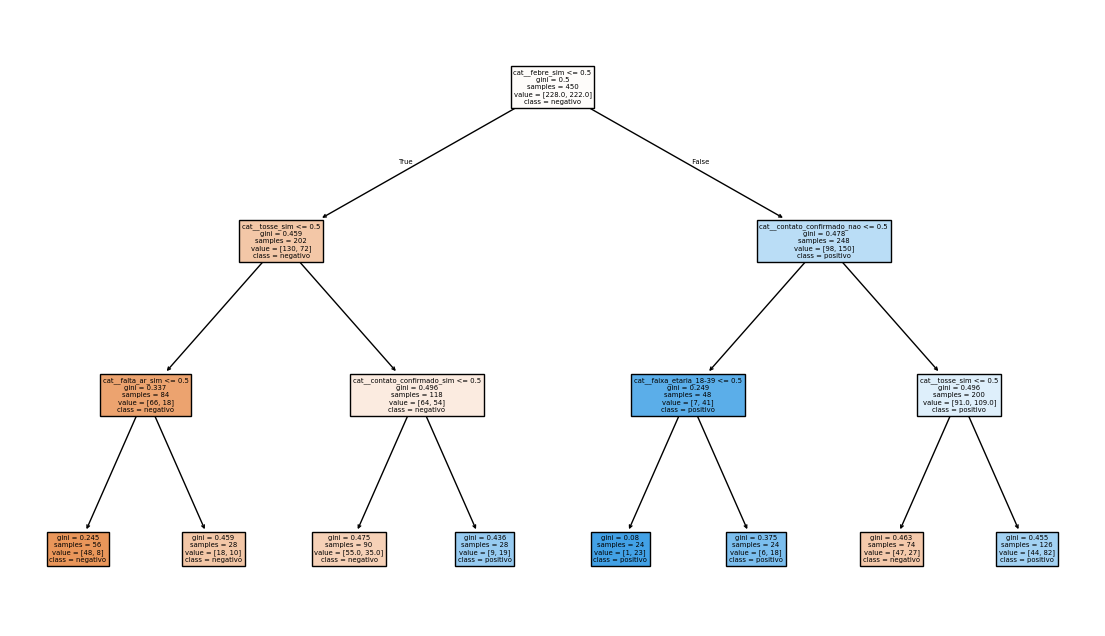

|--- cat__febre_sim <= 0.50
|   |--- cat__tosse_sim <= 0.50
|   |   |--- cat__falta_ar_sim <= 0.50
|   |   |   |--- class: negativo
|   |   |--- cat__falta_ar_sim >  0.50
|   |   |   |--- class: negativo
|   |--- cat__tosse_sim >  0.50
|   |   |--- cat__contato_confirmado_sim <= 0.50
|   |   |   |--- class: negativo
|   |   |--- cat__contato_confirmado_sim >  0.50
|   |   |   |--- class: positivo
|--- cat__febre_sim >  0.50
|   |--- cat__contato_confirmado_nao <= 0.50
|   |   |--- cat__faixa_etaria_18-39 <= 0.50
|   |   |   |--- class: positivo
|   |   |--- cat__faixa_etaria_18-39 >  0.50
|   |   |   |--- class: positivo
|   |--- cat__contato_confirmado_nao >  0.50
|   |   |--- cat__tosse_sim <= 0.50
|   |   |   |--- class: negativo
|   |   |--- cat__tosse_sim >  0.50
|   |   |   |--- class: positivo



In [6]:

small = DecisionTreeClassifier(random_state=42, max_depth=3, min_samples_leaf=10)
small.fit(Xt, y_tr)

plt.figure(figsize=(14,8))
plot_tree(small, filled=True, class_names=small.classes_, feature_names=pre_fitted.get_feature_names_out())
plt.show()

rules = export_text(small, feature_names=list(pre_fitted.get_feature_names_out()))
print(rules)



### Interpretação (explicação)

- **Raiz**: a primeira condição costuma ser a mais informativa (ex.: envolvimento com `contato_confirmado` ou presença de `febre`/`tosse`).  
- **Ramos**: cada teste filtra os casos, tornando as folhas mais “puras”.  
- **Folhas**: mostram a classe prevista. Se as folhas que prevêem `positivo` aparecem após condições como `contato_confirmado=sim` e `febre=sim`, isso indica **regras plausíveis** clinicamente.

> **Leitura prática:** use as regras impressas (acima) como roteiro: transforme cada nível em **SE... ENTÃO...** em português.  
Ex.: “SE `contato_confirmado=sim` **E** `febre=sim`, a árvore tende a classificar como **positivo**; caso contrário, avalia sintomas como `tosse`, `falta_ar` etc.”



## 6) Comparação e conclusão (explicação)

- **Sem poda**: maior risco de sobreajuste, árvore mais longa e difícil de explicar.  
- **Pré-poda**: limita complexidade **desde o início** (mais simples para apresentar).  
- **Pós-poda**: cresce e **simplifica depois**, removendo ramos que não ajudam no desempenho.  

**Regra de ouro:** busque o **equilíbrio** entre **simplicidade** (para explicar e decidir rápido) e **poder preditivo** (métrica no teste).  
Se a pré-podada tiver acurácia semelhante à sem-poda e for bem menor, prefira a **pré-podada** para decisões estratégicas.


In [7]:

def resume_acc(nome, model, X_train, X_test, y_train, y_test):
    print(f"{nome}: treino={accuracy_score(y_train, model.predict(X_train)):.3f} | teste={accuracy_score(y_test, model.predict(X_test)):.3f}")

# Reajuste dos modelos no mesmo espaço transformado (para comparação justa)
tree_base = DecisionTreeClassifier(random_state=42).fit(Xt, y_tr)
tree_pre  = DecisionTreeClassifier(random_state=42, max_depth=4, min_samples_leaf=10).fit(Xt, y_tr)
tree_post = best_tree  # já treinado

resume_acc("Sem poda", tree_base, Xt, Xv, y_tr, y_te)
resume_acc("Pré-podada", tree_pre, Xt, Xv, y_tr, y_te)
resume_acc("Pós-podada", tree_post, Xt, Xv, y_tr, y_te)


Sem poda: treino=0.851 | teste=0.607
Pré-podada: treino=0.696 | teste=0.647
Pós-podada: treino=0.724 | teste=0.647



## 7) Garantir árvore didática (se virar um único nó)
Se a árvore de visualização sair **com apenas 1 nó** (sem splits), forçamos parâmetros **menos restritivos** para gerar uma árvore **representativa** para fins didáticos.


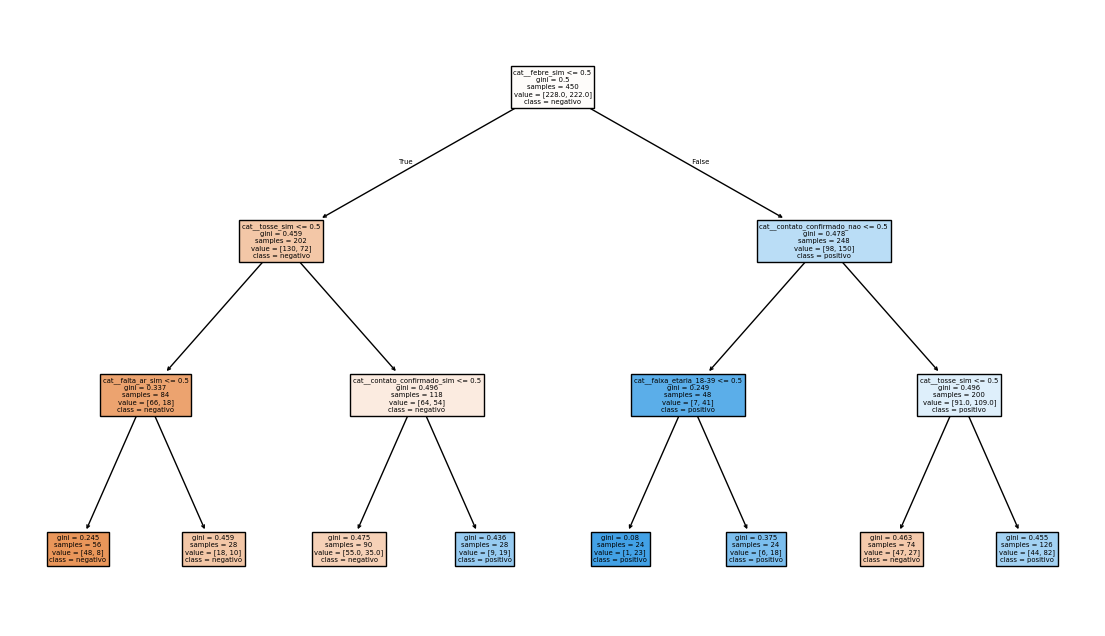

|--- cat__febre_sim <= 0.50
|   |--- cat__tosse_sim <= 0.50
|   |   |--- cat__falta_ar_sim <= 0.50
|   |   |   |--- class: negativo
|   |   |--- cat__falta_ar_sim >  0.50
|   |   |   |--- class: negativo
|   |--- cat__tosse_sim >  0.50
|   |   |--- cat__contato_confirmado_sim <= 0.50
|   |   |   |--- class: negativo
|   |   |--- cat__contato_confirmado_sim >  0.50
|   |   |   |--- class: positivo
|--- cat__febre_sim >  0.50
|   |--- cat__contato_confirmado_nao <= 0.50
|   |   |--- cat__faixa_etaria_18-39 <= 0.50
|   |   |   |--- class: positivo
|   |   |--- cat__faixa_etaria_18-39 >  0.50
|   |   |   |--- class: positivo
|   |--- cat__contato_confirmado_nao >  0.50
|   |   |--- cat__tosse_sim <= 0.50
|   |   |   |--- class: negativo
|   |   |--- cat__tosse_sim >  0.50
|   |   |   |--- class: positivo

Profundidade: 3 | Folhas: 8


In [8]:

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
import numpy as np
import matplotlib.pyplot as plt

def plot_arvore_didatica(Xt, y_tr, feature_names, max_depth=3, min_samples_leaf=5, min_impurity_decrease=1e-4):
    modelo = DecisionTreeClassifier(
        random_state=42,
        criterion="gini",
        splitter="best",
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        min_impurity_decrease=min_impurity_decrease,
        ccp_alpha=0.0
    ).fit(Xt, y_tr)
    if getattr(modelo, "tree_", None) and modelo.tree_.node_count <= 1:
        # Afrouxa mais um pouco
        modelo = DecisionTreeClassifier(
            random_state=42,
            max_depth=max_depth+1,
            min_samples_leaf=max(2, min_samples_leaf//2),
            min_impurity_decrease=0.0,
            ccp_alpha=0.0
        ).fit(Xt, y_tr)

    plt.figure(figsize=(14,8))
    plot_tree(modelo, filled=True, class_names=modelo.classes_, feature_names=feature_names)
    plt.show()

    print(export_text(modelo, feature_names=list(feature_names)))
    print(f"Profundidade: {modelo.get_depth()} | Folhas: {modelo.get_n_leaves()}")

# Usa as matrizes e features que já temos do passo anterior
feature_names = pre_fitted.get_feature_names_out()
plot_arvore_didatica(Xt, y_tr, feature_names)
